In [1]:
# include("Utils.jl")

using Plots

In [192]:
@enum LatticeArrangement begin
    D1Q2
    D2Q9
end

 @enum BoundaryPosition begin
    BoundaryLeft
    BoundaryRight
    BoundaryTop
    BoundaryBottom
    BoundaryBottomRight
    BoundaryBottomLeft
    BoundaryTopRight
    BoundaryTopLeft
end

"""
    LatticeBolzmannMethod(arrangement, tsize, xsize, alpha, weight, initialCondition, boundaryCondition)

# Arguments
- `arrangement::LatticeArrangement`: how lattice are arranged.
- `xsize::Integer`: the number of lattice along x direction start with x = 0 and end with x = xsize.
- `alpha::Float64: the diffusion coefficient in diffusion equation.
- `ysize::Integer=0`: the number of lattice along y direction start with y = 0 and end with y = ysize.
- `zsize::Integer=0`: the number of lattice along z direction start with z = 0 and end with z = zsize.
- `tsize::Integer=100`: the number of lattice along time direction start with t = 0 and end with t = tsize.

# Lattice Arrangement
## D1Q2
- f_1 corresonding to speed c(1)
- f_2 corresonding to speed c(-1)

## D2Q9
- f_9 corresonding to speed c(0,0)
- f_1 corresonding to speed c(1,0)
- f_2 corresonding to speed c(0,1)
- f_3 corresonding to speed c(-1,0)
- f_4 corresonding to speed c(0,-1)
- f_5 corresonding to speed c(1,1)
- f_6 corresonding to speed c(-1,1)
- f_7 corresonding to speed c(-1,-1)
- f_8 corresonding to speed c(1,-1)
"""

function LatticeBolzmannMethod(arrangement::LatticeArrangement,
        tsize::Integer, xsize::Integer,
        alpha::Float64, 
        InitialCondition::Function, BoundaryCondition::Function, SourceTerm::Function)

    # Pre-check
    @assert tsize > 0
    @assert xsize > 0
    
    # non-dimonsionalized scaling and 
    dt = 1.0
    dx = 1.0
    
    # Meta
    if arrangement == D1Q2
        D = 1
        weight = [0.5, 0.5]
        ksize = length(weight)
    else
        error("Unknown Lattice Arrangement. Please check if the dimension specification matches the lattice arrangement.")
    end
    
    # Initiate variables
    speed_of_sound_squared = (dx*dx) / (dt*dt)
    omega = 1.0 / (((D * alpha) / (dt * speed_of_sound_squared)) + 0.5)

    # Initialize data structure by dimensions
    density_data = fill(0.0, xsize, tsize) # store computation result at each time step

    lattice = Array{Any}(undef, xsize)
    for x in 1:xsize
        lattice[x] =  weight .* InitialCondition(x)
    end

    # Main loop
    for t in 1:tsize
        # Collision process
        for x in 1:xsize
            lattice_old = copy(lattice[x])
            
            for k in 1:ksize
                lattice[x][k] = (1.0 - omega) * lattice_old[k] + omega * (weight[k] * (sum(lattice_old))) + dt * weight[k] * SourceTerm(sum(lattice_old))
            end
        end
        
        # Streaming process (D1Q2)
        for x in 1:(xsize-1)
            lattice[xsize-x+1][1] = lattice[xsize-x][1]
            lattice[x][2] = lattice[x+1][2]
        end
        
        # Boundary Conditions
        lattice[xsize] = BoundaryCondition(BoundaryRight, lattice[xsize], lattice[xsize-1])
        lattice[1] = BoundaryCondition(BoundaryLeft, lattice[1], lattice[2])

        # Store Result
        density_data[:, t] = [sum(lattice[x]) for x in 1:xsize]
    end
    
    result = plot(1:xsize, density_data[:, tsize], 
        line = (:blue, 2, 0.8), 
        label = "Temperature After Simulation with t = $t",
        legend = :topright
    )
    display(result)
    
    return density_data[:, tsize]
end

function LatticeBolzmannMethod(arrangement::LatticeArrangement,
        tsize::Integer, xsize::Integer, ysize::Integer,
        alpha::Float64, 
        InitialCondition::Function, BoundaryCondition::Function, SourceTerm::Function)

    # Pre-check
    @assert tsize > 0
    @assert xsize > 0
    @assert ysize > 0
    
    # non-dimonsionalized scaling and 
    dt = 1.0
    dx = 1.0
    dy = 1.0
    
    # Meta
    if arrangement == D2Q9
        D = 2 + 1
        weight = [1/9, 1/9, 1/9, 1/9, 1/36, 1/36, 1/36, 1/36, 4/9]
        ksize = length(weight)
    else
        error("Unknown Lattice Arrangement. Please check if the dimension specification matches the lattice arrangement.")
    end
    
    # Initiate variables
    speed_of_sound_squared = (dx*dx) / (dt*dt)
    omega = 1.0 / (((D * alpha) / (dt * speed_of_sound_squared)) + 0.5)

    # Initialize data structure by dimensions
    density_data = fill(0.0, ysize, xsize, tsize) # store computation result at each time step

    lattice = Array{Any}(undef, xsize, ysize)
    for x in 1:xsize, y in 1:ysize
        lattice[x, y] = weight .* InitialCondition(x, y)
    end

    # Main loop
    for t in 1:tsize
        # Collision process
        for x in 1:xsize, y in 1:ysize
            lattice_old = copy(lattice[x, y])
            for k in 1:ksize
                lattice[x, y][k] = (1.0 - omega) * lattice_old[k] + omega * (weight[k] * (sum(lattice_old))) + dt * weight[k] * SourceTerm(sum(lattice_old))
            end
        end

        # Streaming process (D2Q9)
        for x in 1:(xsize-1), y in 1:(ysize-1)
                lattice[xsize-x+1, y][1] = lattice[xsize-x, y][1]
                lattice[x, y][3] = lattice[x+1, y][3]
                lattice[x, ysize-y+1][2] = lattice[x, ysize-y][2]
                lattice[x, y][4] = lattice[x, y+1][4]
                lattice[x, y][7] = lattice[x+1, y+1][7]
                lattice[xsize-x+1, ysize-y+1][5] = lattice[xsize-x, ysize-y][5]
                lattice[x, ysize-y+1][6] = lattice[x+1, ysize-y][6]
                lattice[xsize-x+1, y][8] = lattice[xsize-x, y+1][8]
        end
        
        # Boundary conditions
        for x in 1:xsize
            lattice[x, ysize] = BoundaryCondition(BoundaryTop, lattice[x, ysize], lattice[x, ysize-1])
            lattice[x, 1] = BoundaryCondition(BoundaryBottom, lattice[x, 1], lattice[x, 2])
        end

        for y in 1:ysize
            lattice[xsize, y] = BoundaryCondition(BoundaryRight, lattice[xsize, y], lattice[xsize-1, y])
            lattice[1, y] = BoundaryCondition(BoundaryLeft, lattice[1, y], lattice[2, y])
        end
        
        # Store Result
        density_data[:, :, t] = transpose(sum.(lattice))
    end
    
    result = heatmap(1:xsize, 1:ysize, density_data[:, :, tsize],
        title = "Temperature After Simulation with t = $t",
        color = :viridis,
        xlabel = "X",
        ylabel = "Y",
        legend = :topright
    )
    display(result)
    
    return density_data[:, :, tsize]
end

LatticeBolzmannMethod (generic function with 2 methods)

In [193]:
function BoundaryCondition1D_3_5_2(position, boundaryNode, CloestNode)
    if position == BoundaryLeft
        boundaryNode[1] = 1.0 - boundaryNode[2]  # Constant temperature boundary condition
    elseif position == BoundaryRight
        boundaryNode = CloestNode  # Adiabatic boundary condition
    end
    return boundaryNode
end

function BoundaryCondition2D_3_10_1(position, boundaryNode, CloestNode)
    LeftTemperature = 1.0
    RightTemperature = 0.0
    TopTemperature = 0.0
    BottomTemperature = 0.0
    weight = [1/9, 1/9, 1/9, 1/9, 1/36, 1/36, 1/36, 1/36, 4/9]
    if position == BoundaryLeft
        boundaryNode[5] = (weight[5]+weight[7])*LeftTemperature - boundaryNode[7]  # Constant temperature boundary condition
        boundaryNode[1] = (weight[1]+weight[3])*LeftTemperature - boundaryNode[3]  # Constant temperature boundary condition
        boundaryNode[8] = (weight[8]+weight[6])*LeftTemperature - boundaryNode[6]  # Constant temperature boundary condition
        
        # boundaryNode = CloestNode  # Adiabatic boundary condition
    elseif position == BoundaryRight
        boundaryNode[6] = (weight[6]+weight[8])*RightTemperature - boundaryNode[8]  # Constant temperature boundary condition
        boundaryNode[3] = (weight[3]+weight[1])*RightTemperature - boundaryNode[1]  # Constant temperature boundary condition
        boundaryNode[7] = (weight[7]+weight[5])*RightTemperature - boundaryNode[5]  # Constant temperature boundary condition
    
        # boundaryNode = CloestNode  # Adiabatic boundary condition
    elseif position == BoundaryTop
        boundaryNode[7] = (weight[7]+weight[5])*TopTemperature - boundaryNode[5]  # Constant temperature boundary condition
        boundaryNode[4] = (weight[4]+weight[2])*TopTemperature - boundaryNode[2]  # Constant temperature boundary condition
        boundaryNode[8] = (weight[8]+weight[6])*TopTemperature - boundaryNode[6]  # Constant temperature boundary condition
        
        # boundaryNode = CloestNode  # Adiabatic boundary condition
    elseif position == BoundaryBottom
        # boundaryNode[6] = (weight[6]+weight[8])*BottomTemperature - boundaryNode[8]  # Constant temperature boundary condition
        # boundaryNode[2] = (weight[2]+weight[4])*BottomTemperature - boundaryNode[4]  # Constant temperature boundary condition
        # boundaryNode[5] = (weight[5]+weight[7])*BottomTemperature - boundaryNode[7]  # Constant temperature boundary condition
        
        boundaryNode = CloestNode  # Adiabatic boundary condition
    end
    return boundaryNode
end

function Source(node_value)
    node_value += 0.00001
    qg = 0.1
    cp = 0.1
    return qg / (node_value * cp)
end

Source (generic function with 1 method)

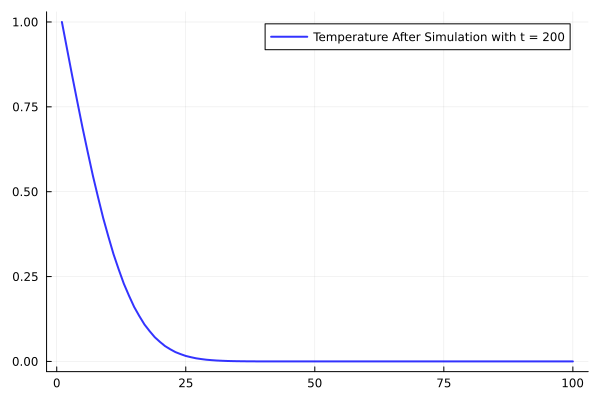

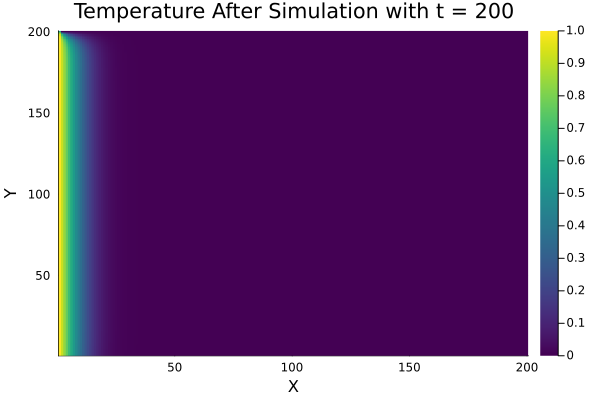

In [194]:
t = 200
A = LatticeBolzmannMethod(D1Q2, t, 100, 0.25, x -> 0.0, BoundaryCondition1D_3_5_2, x -> 0.0);
B, latt = LatticeBolzmannMethod(D2Q9, t, 200, 200, 0.25, (x, y) -> 0.0, BoundaryCondition2D_3_10_1, x -> 0.0);